# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you a good idea whether a species might be a "keystone" species 

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GLOBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then create a network diagram to visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GLoBI (https://curiositydata.org/part1_globi_access/).

In [290]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [291]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ

### Setting up some parameters

In [292]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and biirds
thresholdForOccNum = 5

In [293]:
## Define the country of interest
country  = 'BE'

## Define the year from where to consider records for the occupancy
year = 2000

### Define the key taxon for the notebook for which to find all interactions


In [294]:
#taxon = "Oxalis corniculata"
#taxon = "Oxalis pes-caprae"
#taxon = "Abramis brama"
#taxon = "Dikerogammarus villosus" # killer shrimp
#taxon = "Lantanophaga pusillidactyla"
#taxon = "Lantana camara"
#taxon = "Cirsium vulgare"
#taxon = "Solenopsis invicta"
#taxon = "Linepithema humile" #Argentine ant
taxon = "Procyon lotor" # raccoon
#taxon = "Carpobrotus edulis"
#taxon = "not exist"
#taxon = "Sciurus carolinensis" # Eastern grey squirrel

## Load the GLoBI data

The current snapshot of GLoBI was taken on 2019-11-05 from https://depot.globalbioticinteractions.org/snapshot/target/data/tsv/interactions.tsv.gz


In [297]:
# This takes a few minutes to load in.
# the low_memory=False property will get rid of a warning, but will not help if there is really no memory left
data = pd.read_csv('..//data//interactions.tsv', delimiter='\t', encoding='utf-8', low_memory=False)
len(data)

4041938

In [298]:
# Take a little look at the data to make sure it makes sense
data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
0,EOL:12001247,EOL:12001247 | WORMS:579844 | WD:Q13393587 | O...,Leptoconchus massini,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus massini,EOL:12001247,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
1,EOL:12001247,EOL:12001247 | WORMS:579844 | WD:Q13393587 | O...,Leptoconchus massini,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus massini,EOL:12001247,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
2,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | NCB...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
3,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | NCB...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
4,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | NCB...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z


In [762]:
data.columns

Index(['sourceTaxonId', 'sourceTaxonIds', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonPathNames', 'sourceTaxonPathIds',
       'sourceTaxonPathRankNames', 'sourceTaxonSpeciesName',
       'sourceTaxonSpeciesId', 'sourceTaxonGenusName', 'sourceTaxonGenusId',
       'sourceTaxonFamilyName', 'sourceTaxonFamilyId', 'sourceTaxonOrderName',
       'sourceTaxonOrderId', 'sourceTaxonClassName', 'sourceTaxonClassId',
       'sourceTaxonPhylumName', 'sourceTaxonPhylumId',
       'sourceTaxonKingdomName', 'sourceTaxonKingdomId', 'sourceId',
       'sourceOccurrenceId', 'sourceCatalogNumber', 'sourceBasisOfRecordId',
       'sourceBasisOfRecordName', 'sourceLifeStageId', 'sourceLifeStageName',
       'sourceBodyPartId', 'sourceBodyPartName', 'sourcePhysiologicalStateId',
       'sourcePhysiologicalStateName', 'interactionTypeName',
       'interactionTypeId', 'targetTaxonId', 'targetTaxonIds',
       'targetTaxonName', 'targetTaxonRank', 'targetTaxonPathNames',
       'targetTaxonPath

## Drop duplicates

This line gets rid of duplicate interations. I currently can't see a reason to keep them, but this perhaps should be checked. 
Some more common interactions might have more support in the literature and therefore more records. Deduplicating them tends to equal out rare interactions with common ones.

In [299]:
data.drop_duplicates(['sourceTaxonName', 'interactionTypeName', 'targetTaxonName'], inplace = True)

In [300]:
## Check how many rows are left
len(data)

1129416

## Remove ranks that are not species
Many entries in GLoBI are non-specific interations at a high taxonomic level. For example, roses are visited by bees.
I have chossen to remove these interactions from the study, at least preliminarly

In [301]:
data.drop(data[data['sourceTaxonRank'] != 'species'].index, inplace = True)
data.drop(data[data['targetTaxonRank'] != 'species'].index, inplace = True)

In [302]:
## Check how many rows are left
len(data)

542104

## Remove "interactsWith"
There are many vague interactions with the term interactsWith. These aren't really that useful, because it could be any kind of interaction, positive or negative, direct or indirect.
Unwanted interactions can be removed as an option by removing the commenting from these lines

In [303]:
data = data[data.interactionTypeName != 'interactsWith']

#data = data[data.interactionTypeName != 'visitsFlowersOf']

#data = data[data.interactionTypeName != 'pollinates']

len(data)

396002

## Check to see if the taxon exits in GBIF

In [304]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [305]:

print('The taxon to be studied is ' + match['scientificName'])

The taxon to be studied is Procyon lotor (Linnaeus, 1758)


In [306]:
# What are all the types of interactions involving taxon as source taxon?
data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()

array(['eats', 'preysOn'], dtype=object)

In [307]:
# What are all the types of interactions involving taxon as target taxon?
data[data['targetTaxonName'] == taxon]['interactionTypeName'].unique()

array(['eats', 'parasiteOf', 'pathogenOf', 'ectoParasiteOf', 'hasHost',
       'preysOn', 'endoparasiteOf'], dtype=object)

How many taxon sources do I have?

In [308]:
len(data[data['sourceTaxonName'] == taxon])

88

How many taxon targets do I have?

In [309]:
len(data[data['targetTaxonName'] == taxon])

245

## Get the primary interation data for the species in question

In [310]:
    interactDataTaxon = data[data['targetTaxonName'] == taxon]
    interactDataTaxon = interactDataTaxon.append(data[data['sourceTaxonName'] == taxon])

In [311]:
interactDataTaxon.count()

sourceTaxonId                   333
sourceTaxonIds                  333
sourceTaxonName                 333
sourceTaxonRank                 333
sourceTaxonPathNames            333
sourceTaxonPathIds              325
sourceTaxonPathRankNames        333
sourceTaxonSpeciesName          331
sourceTaxonSpeciesId            325
sourceTaxonGenusName            328
sourceTaxonGenusId              322
sourceTaxonFamilyName           328
sourceTaxonFamilyId             322
sourceTaxonOrderName            318
sourceTaxonOrderId              312
sourceTaxonClassName            316
sourceTaxonClassId              310
sourceTaxonPhylumName           316
sourceTaxonPhylumId             311
sourceTaxonKingdomName          313
sourceTaxonKingdomId            310
sourceId                         13
sourceOccurrenceId                0
sourceCatalogNumber               0
sourceBasisOfRecordId            11
sourceBasisOfRecordName          12
sourceLifeStageId                 8
sourceLifeStageName         

## Get a list of all the primary interacting species

In [312]:
interactingTaxa = pd.DataFrame(interactDataTaxon['sourceTaxonName'].append(interactDataTaxon['targetTaxonName']).unique())

In [313]:
interactingTaxa

,0
0,Bubo virginianus
1,Cathartes aura
2,Coragyps atratus
3,Aquila chrysaetos
4,Haliaeetus leucocephalus
5,Aonchotheca putorii
6,Macracanthorhynchus ingens
7,Molineus barbatus
8,Dracunculus insignis
9,Spirometra mansonoides


## Get all the secondary interactions

In [314]:
for name in interactingTaxa[0]:
    interactDataTaxon = interactDataTaxon.append(data[data['targetTaxonName'] == name])
    interactDataTaxon = interactDataTaxon.append(data[data['sourceTaxonName'] == name])

In [315]:
interactDataTaxon.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
198115,EOL_V2:914958,EOL_V2:914958 | OTT:509853 | ITIS:177884 | IRM...,Bubo virginianus,species,Animalia | Chordata | Aves | Strigiformes | St...,EOL:1 | EOL:694 | EOL:695 | EOL:696 | EOL:8660...,kingdom | phylum | class | order | family | ge...,Bubo virginianus,EOL_V2:914958,Bubo,...,2.209248e+11,https://en.wiktionary.org/wiki/support,"Bosakowski, T., R. Speiser, and D. G. Smith. 1...",NaN,NaN,Allen Hurlbert. 2017. Avian Diet Database.,Dryu0003/dietdatabase,https://github.com/Dryu0003/dietdatabase/archi...,NaN,2019-12-11T00:07:00.214Z
209176,EOL_V2:1049010,EOL_V2:1049010 | OTT:9106 | WD:Q245181 | WORMS...,Cathartes aura,species,Animalia | Chordata | Aves | Accipitriformes |...,EOL:1 | EOL:694 | EOL:695 | EOL:2942901 | EOL:...,kingdom | phylum | class | order | family | ge...,Cathartes aura,EOL_V2:1049010,Cathartes,...,1.681344e+11,https://en.wiktionary.org/wiki/support,"Thiel, R. P. 1976. Activity patterns and food ...",NaN,NaN,Allen Hurlbert. 2017. Avian Diet Database.,Dryu0003/dietdatabase,https://github.com/Dryu0003/dietdatabase/archi...,NaN,2019-12-11T00:07:00.214Z
209291,ITIS:175272,ITIS:175272 | OTT:316995 | EOL_V2:1049011 | GB...,Coragyps atratus,species,Animalia | Bilateria | Deuterostomia | Chordat...,ITIS:202423 | ITIS:914154 | ITIS:914156 | ITIS...,kingdom | subkingdom | infrakingdom | phylum |...,Coragyps atratus,ITIS:175272,Coragyps,...,4.232736e+11,https://en.wiktionary.org/wiki/support,"Coleman, J. S. and J. D. Fraser. 1987. Food ha...",NaN,NaN,Allen Hurlbert. 2017. Avian Diet Database.,Dryu0003/dietdatabase,https://github.com/Dryu0003/dietdatabase/archi...,NaN,2019-12-11T00:07:00.214Z
214225,EOL_V2:1049119,EOL_V2:1049119 | OTT:263127 | INAT_TAXON:5074 ...,Aquila chrysaetos,species,Animalia | Chordata | Aves | Accipitriformes |...,EOL:1 | EOL:694 | EOL:695 | EOL:2942901 | EOL:...,kingdom | phylum | class | order | family | ge...,Aquila chrysaetos,EOL_V2:1049119,Aquila,...,-6.315840e+10,https://en.wiktionary.org/wiki/support,"Mollhagen, T. R., R. W. Wiley, and R. L. Packa...",10.2307/3799431,NaN,Allen Hurlbert. 2017. Avian Diet Database.,Dryu0003/dietdatabase,https://github.com/Dryu0003/dietdatabase/archi...,NaN,2019-12-11T00:07:00.214Z
216493,EOL_V2:1049121,EOL_V2:1049121 | OTT:1012350 | INAT_TAXON:5305...,Haliaeetus leucocephalus,species,Animalia | Chordata | Aves | Accipitriformes |...,EOL:1 | EOL:694 | EOL:695 | EOL:2942901 | EOL:...,kingdom | phylum | class | order | family | ge...,Haliaeetus leucocephalus,EOL_V2:1049121,Haliaeetus,...,1.577664e+11,https://en.wiktionary.org/wiki/support,"McEwan, L. C. and D. H. Hirth. 1980. Food habi...",10.2307/1367485,NaN,Allen Hurlbert. 2017. Avian Diet Database.,Dryu0003/dietdatabase,https://github.com/Dryu0003/dietdatabase/archi...,NaN,2019-12-11T00:07:00.214Z


In [316]:
interactingTaxa = pd.DataFrame(interactDataTaxon['sourceTaxonName'].append(interactDataTaxon['targetTaxonName']).unique())

In [317]:
interactingTaxa

,0
0,Bubo virginianus
1,Cathartes aura
2,Coragyps atratus
3,Aquila chrysaetos
4,Haliaeetus leucocephalus
5,Aonchotheca putorii
6,Macracanthorhynchus ingens
7,Molineus barbatus
8,Dracunculus insignis
9,Spirometra mansonoides


In [768]:
    cleanInteractDataTaxon = interactDataTaxon[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonFamilyName', 'interactionTypeName',
       'targetTaxonName','targetTaxonRank', 'sourceCitation', 'sourceDOI'
        ]].dropna(subset=['targetTaxonName','sourceTaxonName'])

In [769]:
cleanInteractDataTaxon.head()

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonRank,sourceCitation,sourceDOI
198115,EOL_V2:914958,Bubo virginianus,species,Strigidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209176,EOL_V2:1049010,Cathartes aura,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209291,ITIS:175272,Coragyps atratus,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
214225,EOL_V2:1049119,Aquila chrysaetos,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
216493,EOL_V2:1049121,Haliaeetus leucocephalus,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN


In [770]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon['interactionTypeName'].unique()

array(['eats', 'parasiteOf', 'pathogenOf', 'ectoParasiteOf', 'hasHost',
       'preysOn', 'endoparasiteOf', 'symbiontOf', 'hasVector',
       'visitsFlowersOf', 'mutualistOf', 'livesInsideOf',
       'commensalistOf', 'hasDispersalVector'], dtype=object)

In [772]:
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
parasiteOf            4197
eats                  2667
hasHost               2170
preysOn               1186
endoparasiteOf         724
pathogenOf             663
ectoParasiteOf         189
symbiontOf              59
mutualistOf              9
visitsFlowersOf          6
hasVector                3
livesInsideOf            2
hasDispersalVector       1
commensalistOf           1
dtype: int64

In [773]:
len(cleanInteractDataTaxon)

11877

In [774]:
cleanInteractDataTaxon.head()

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonRank,sourceCitation,sourceDOI
198115,EOL_V2:914958,Bubo virginianus,species,Strigidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209176,EOL_V2:1049010,Cathartes aura,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209291,ITIS:175272,Coragyps atratus,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
214225,EOL_V2:1049119,Aquila chrysaetos,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
216493,EOL_V2:1049121,Haliaeetus leucocephalus,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN


## Create a file with all the nodes and their attributes

In [775]:
# Get the source nodes
nodes = cleanInteractDataTaxon.drop_duplicates(subset=['sourceTaxonName'])

In [776]:
# Get the target nodes
nodes = nodes.append(cleanInteractDataTaxon.drop_duplicates(subset=['targetTaxonName']))

In [777]:
nodes.head()

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonRank,sourceCitation,sourceDOI
198115,EOL_V2:914958,Bubo virginianus,species,Strigidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209176,EOL_V2:1049010,Cathartes aura,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
209291,ITIS:175272,Coragyps atratus,species,Cathartidae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
214225,EOL_V2:1049119,Aquila chrysaetos,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN
216493,EOL_V2:1049121,Haliaeetus leucocephalus,species,Accipitridae,eats,Procyon lotor,species,Allen Hurlbert. 2017. Avian Diet Database.,NaN


In [778]:
interactingTaxa.count()


0    4186
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [328]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [329]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [330]:
taxaFound = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in interactingTaxa.iterrows():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        print(name[1][0])
        taxaFound[name[1][0]] = False
    else:
        taxaFound[name[1][0]] = GBIFName['usageKey']
    

Taxa from GLoBI, but not found in GBIF
Trypanosoma cruzi
Capillaria putorii
Alaria taxideae
Orthopoxvirus
Raccoon-associated polyomavirus 2
Parvovirus
Rabies virus
Canine distemper virus
Feline panleukopenia virus
West virus
Newcastle disease virus
Influenza virus
Salmonella phage Vi II-E1
Salmonella phage ST160
Salmonella phage SEN5
Salmonella phage SEN4
Salmonella phage SEN22
Salmonella phage SEN1
Salmonella phage SE1 (in:P22virus)
Salmonella phage MA12
Salmonella phage BP63
Salmonella phage BP12C
Salmonella phage BP12B
Salmonella phage BP12A
Salmonella phage 64795_sal3
Salmonella phage 118970_sal4
Salmonella phage 118970_sal3
Salmonella phage 118970_sal1
Salmonella phage 103203_sal5
Salmonella phage
Enterobacteria phage
Suffolk virus
Flavivirus
Avian-like circovirus
Staphylococcus phage YMC/09/04/R1988
Staphylococcus phage vB_SauS_phi2
Staphylococcus phage tp310-3
Staphylococcus phage tp310-2
Staphylococcus phage tp310-1
Staphylococcus phage TEM123
Staphylococcus phage StauST398-5
S

Duck faeces associated circular DNA virus 1
Duck astrovirus
Duck associated cyclovirus 1
Duck hepatitis virus
Avian paramyxovirus
Duck parvovirus
Chicken astrovirus
Duck adenovirus
Goose parvovirus
Turkey astrovirus
Eimeria paludosa
Trichomonas batrachorum
Karotomorpha bufonis
Entamoeba ranarum
Bufonid herpesvirus 1
Plasmodium relictum
Sparrow coronavirus HKU17
Plasmodium circumflexum
Fort virus
Leucocytozoon gentili
Trypanosoma bufophlebotomi
Leucocytozoon dubreuili
Capillaria michiganensis
Eptesipox virus
Eptesicus fuscus gammaherpesvirus
Capillaria palmata
Parastrongylus schmidti
Parastrongylus siamensis
Cardiovirus
Black virus
Tamiami virus
Chelonid herpesvirus 5
Rabbit coronavirus HKU14
Mouse
Ficus carica
nan


In [331]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [332]:
len(taxaFound)

4187

In [333]:
taxaFound.head(2)

,0
Bubo virginianus,5959118
Cathartes aura,2481930


## Create a SQLite database with APSW

In [334]:
import sqlite3
from sqlite3 import Error

In [335]:
database = r"..\data\cube.db"
try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [336]:

 
sql_create_cube_table = """ CREATE TABLE IF NOT EXISTS cube (
                                        year integer,
                                        eea_cell_code text NOT NULL,
                                        taxonKey integer,
                                        n integer,
                                        min_coord_uncertainty float
                                    ); """
 

In [337]:
# create table
try:
    conn.execute(sql_create_cube_table)
except Error as e:
    print(e)

## Clear down the table before filling it up again

In [49]:

conn.execute('DELETE FROM cube')

In [52]:
#with open(r"C:\Users\quentin\Documents\occ-processing\data\processed\cube_belgium.tsv", "r") as f:
with open(r"..\..\..\GitHub\occ-processing\data\processed\cube_belgium.tsv", "r") as f:        
    rows = f.readlines()
    for row in rows:
        fields = row.split('\t')
        conn.execute(f'INSERT INTO cube(year, eea_cell_code, taxonKey, n, min_coord_uncertainty)'\
                     f"VALUES ('{fields[0]}','{fields[1]}','{fields[2]}','{fields[3]}','{fields[4]}')") 
conn.commit()

In [338]:
pd.read_sql_query('SELECT count(year) FROM cube',conn)

,count(year)
0,913355


In [339]:
conn.close()

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [340]:
def speciesCountInCube(conn, key):
    count = 0
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [341]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [342]:
for GBIFtaxon in taxaFound.iterrows():
    #print('{0} found {1} time in Belgium.'.format(GBIFtaxon,speciesCountInGBIF(GBIFtaxon,country)))
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    if GBIFOccCount[0][0] > thresholdForOccNum: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Haliaeetus leucocephalus with key 2480446 occurs in 12 km squares.
Buteo jamaicensis with key 2480542 occurs in 9 km squares.
Procyon lotor with key 5218786 occurs in 1566 km squares.
Bucephala albeola with key 2498329 occurs in 9 km squares.
Caracara cheriway with key 2480985 occurs in 17 km squares.
Prunus serotina with key 3021850 occurs in 5601 km squares.
Oxyura jamaicensis with key 2498305 occurs in 369 km squares.
Anas cyanoptera with key 2498139 occurs in 18 km squares.
Anas americana with key 2498154 occurs in 132 km squares.
Meleagris gallopavo with key 9606290 occurs in 16 km squares.
Phasianus colchicus with key 9752149 occurs in 12431 km squares.
Falco sparverius with key 9685907 occurs in 9 km squares.
Felis catus with key 2435035 occurs in 2337 km squares.
Lithobates catesbeianus with key 2427091 occurs in 156 km squares.
Branta canadensis with key 5232437 occurs in 11324 km squares.
Neovison vison with key 2433652 occurs in 34 km squares.
Aix sponsa with key 2498387 occ

In [343]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [344]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 111


In [345]:
taxaFoundInCountry

,count,key,species
0,12,2480446,Haliaeetus leucocephalus
1,9,2480542,Buteo jamaicensis
2,1566,5218786,Procyon lotor
3,9,2498329,Bucephala albeola
4,17,2480985,Caracara cheriway
5,5601,3021850,Prunus serotina
6,369,2498305,Oxyura jamaicensis
7,18,2498139,Anas cyanoptera
8,132,2498154,Anas americana
9,16,9606290,Meleagris gallopavo


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [346]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

In [347]:
# Create graphic object
G = nx.DiGraph()

In [348]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

len(list(G.nodes))

0

## Figure out which node has the most records

In [349]:
maxRecords = taxaFoundInCountry.max()["count"]
print(maxRecords)

12431


## Add the nodes and the edges to the graph

In [350]:
dictOfNodeSizes = {}

# iterate over rows with iterrows()

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'])
    dictOfNodeSizes[row['species']] = int(row['count']/maxRecords*100)

    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print(row2['species'])
                if row2['species'] == edge[1]['targetTaxonName']: 
                    #print('C: ', edge[1]['sourceTaxonName'],row2['species'])
                    G.add_edge(edge[1]['sourceTaxonName'], row2['species'], label = edge[1]['interactionTypeName'])
                    
len(list(G.nodes))


111

In [351]:
# iterate over rows with iterrows()
for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print(edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'],row['species'])
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print(row2['species'])
                if row2['species'] == edge[1]['sourceTaxonName']: 
                    #print(edge[1]['targetTaxonName'],row2['species'])
                    G.add_edge(row2['species'], edge[1]['targetTaxonName'], label = edge[1]['interactionTypeName'])

In [352]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 111
Number of edges = 53


In [353]:
len(dictOfNodeSizes)

111

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [354]:
for n in list(G.nodes):
    if G.degree(n) == 0:
        G.remove_node(n)

In [355]:
len(G.nodes)

37

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [356]:
listOfNodeSizes = []

for node in list(G.nodes):
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

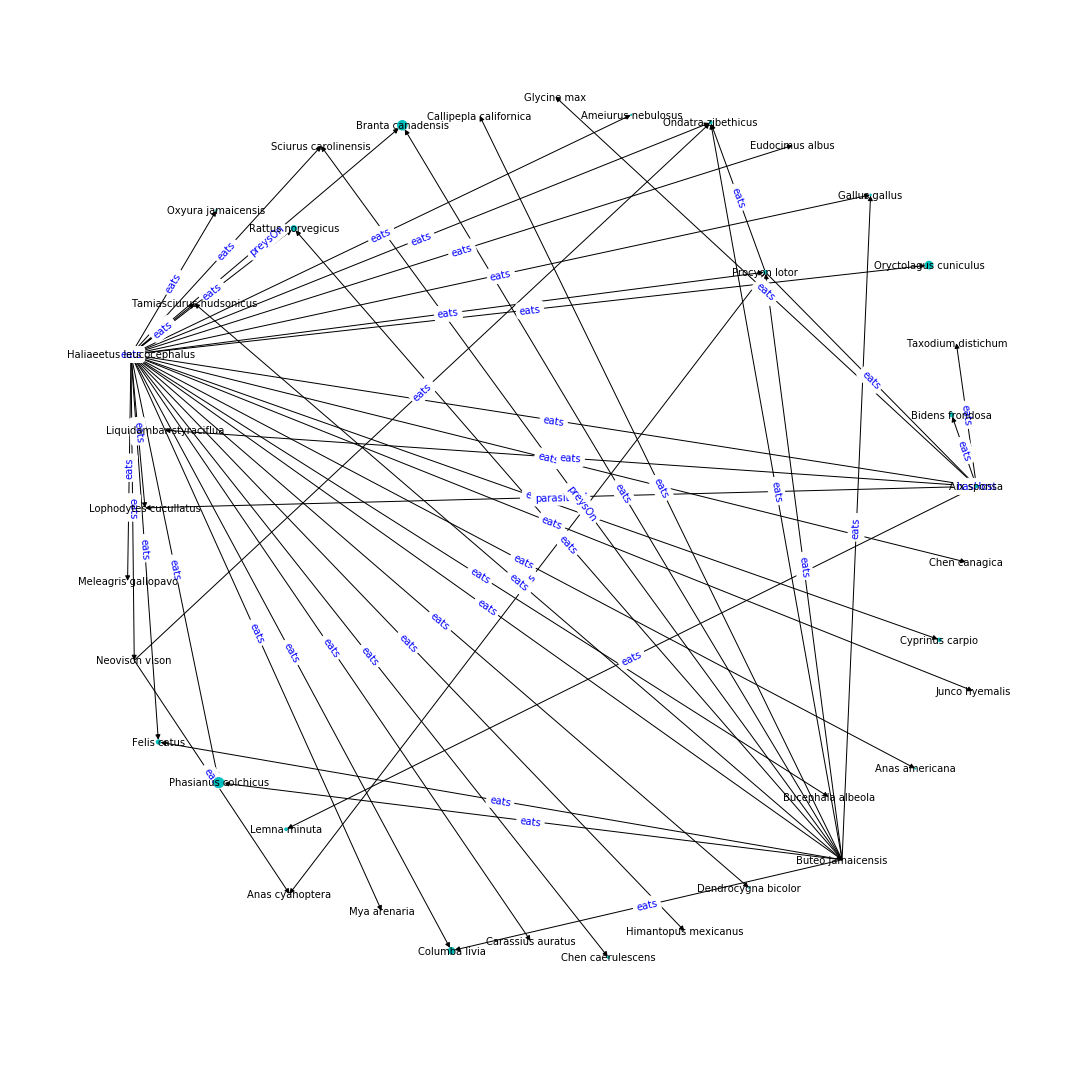

In [357]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [822]:
with open(taxon+country+".html", "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [823]:
with open(taxon+country+".html", "a") as file:
    file.write("<table><th>Species</th><th>Occupancy</th>")
    

In [824]:
species = list(G.nodes)
species.sort()
with open(taxon+country+".html", "a") as file:
    for n in species:
        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")
        #file.write("<a href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a>, "+str(dictOfNodeSizes[n])+"\n")

In [825]:
with open(taxon+country+".html", "a") as file:
    file.write("</table>")    
file.close()

In [826]:
with open(taxon+country+".html", "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [827]:
file = open(taxon+country+".html", "a")
for n in species:
    file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, },\n")
file.close()

### Write edges to file

In [828]:
file = open(taxon+country+".html", "a")
for edge in list(G.edges):
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [829]:
with open(taxon+country+".html", "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'darkgreen', \n\
                label: 'data(id)', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '12px', \n\
                'width': 'mapData(occnum, 0, 400, 3, 150)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 150)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '12px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
            },  \n\
            {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'background-color': 'red'  \n\
            }  \n\
        }], \n\
layout:  { \n\
            name: 'circle', padding: 10, animate: false, gravity: 30, animationDuration: 1000 \n\
     } \n\
} \n\
); \n\
cy.userZoomingEnabled( false ); \n\
</script> \n\
")

In [830]:
with open(taxon+country+".html", "a") as file:
    file.write("<h2>References</h2><ul>\n")

In [831]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
file = open(taxon+country+".html", "a")
for ref in citations:
    file.write("<li>"+str(ref)+"</li>\n")
file.close()

In [832]:
with open(taxon+country+".html", "a") as file:
    file.write("</ul> \
        </body> \
        </html>")